In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import anndata as ad
import scanpy as sc
import squidpy as sq
import scvi

In [2]:
in_dir = "../../results/10_stereo_seq/02_integrate_data"
out_dir = "../../results/10_stereo_seq/03_integrate_data"

os.makedirs(out_dir, exist_ok=True)

In [3]:
adata = sc.read_h5ad(f"{in_dir}/adata.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 37603 × 23475
    obs: 'sample', 'condition', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
adata.raw = adata.copy()

In [6]:
# remove MT genes
mt_genes = adata.var_names.str.startswith('MT-')
adata = adata[:, ~mt_genes]

In [7]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    subset=True,
)

In [8]:
# run scVI without continuous covariate
scvi.model.SCVI.setup_anndata(adata, 
                              layer="counts", 
                              batch_key="sample",
                              continuous_covariate_keys=["total_counts"])

model = scvi.model.SCVI(adata, n_layers=2, n_latent=15, gene_likelihood="nb")

CUDA backend failed to initialize: Found cuDNN version 8500, but JAX was built against version 8904, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 213/213: 100%|██████████| 213/213 [06:26<00:00,  1.80s/it, v_num=1, train_loss_step=105, train_loss_epoch=100]  

`Trainer.fit` stopped: `max_epochs=213` reached.


Epoch 213/213: 100%|██████████| 213/213 [06:26<00:00,  1.82s/it, v_num=1, train_loss_step=105, train_loss_epoch=100]


In [10]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [11]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

2024-12-24 16:04:58.208848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735056298.226150 2649559 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735056298.231296 2649559 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


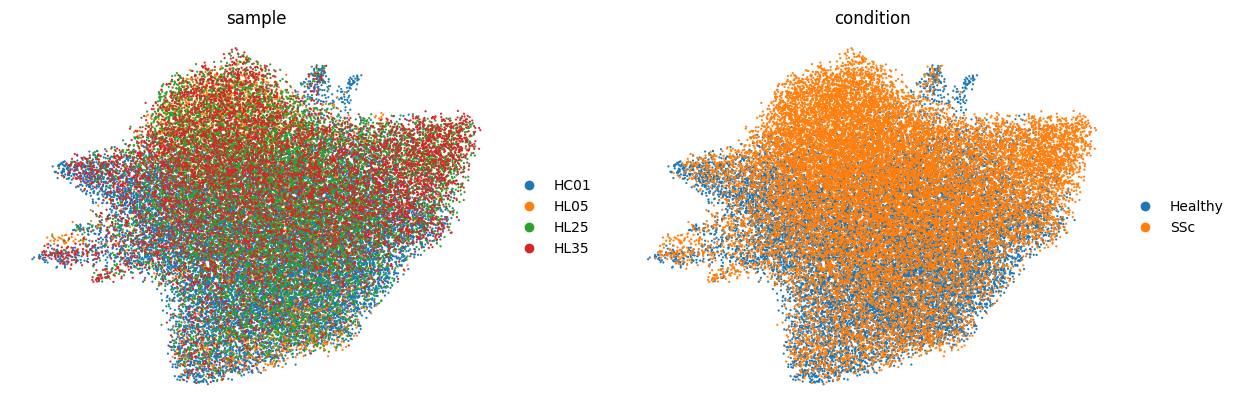

In [12]:
sc.pl.umap(adata, color=["sample", "condition"], size=10, frameon=False)

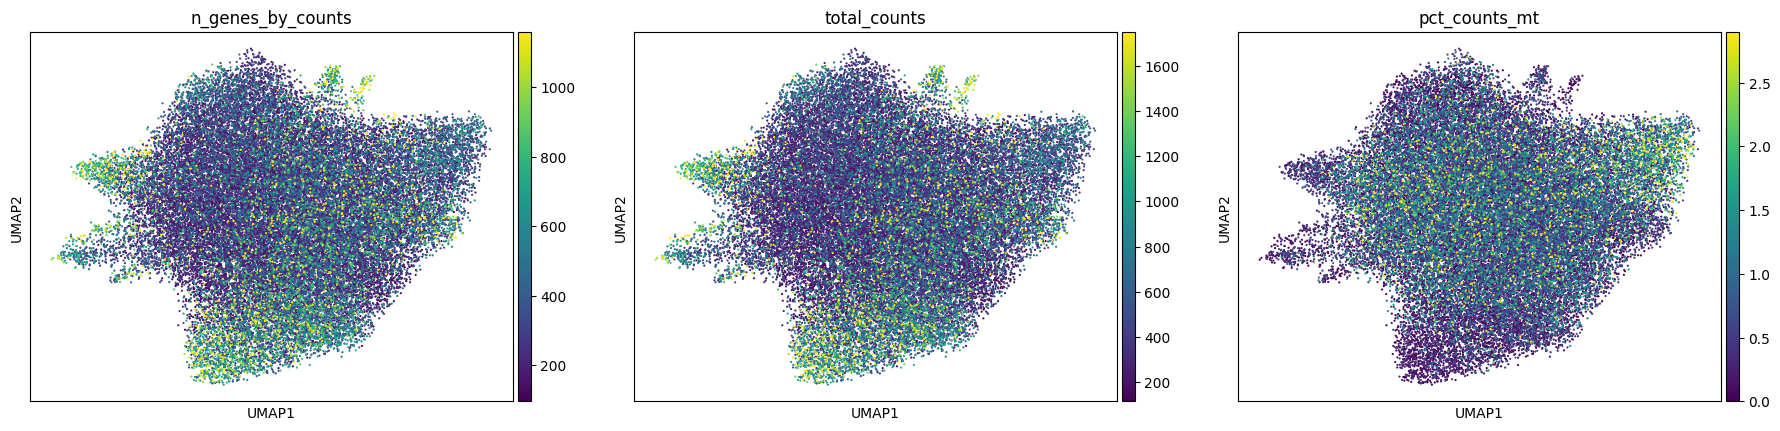

In [13]:
sc.pl.umap(
    adata,
    color=["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    size=10,
    vmax='p99'
)

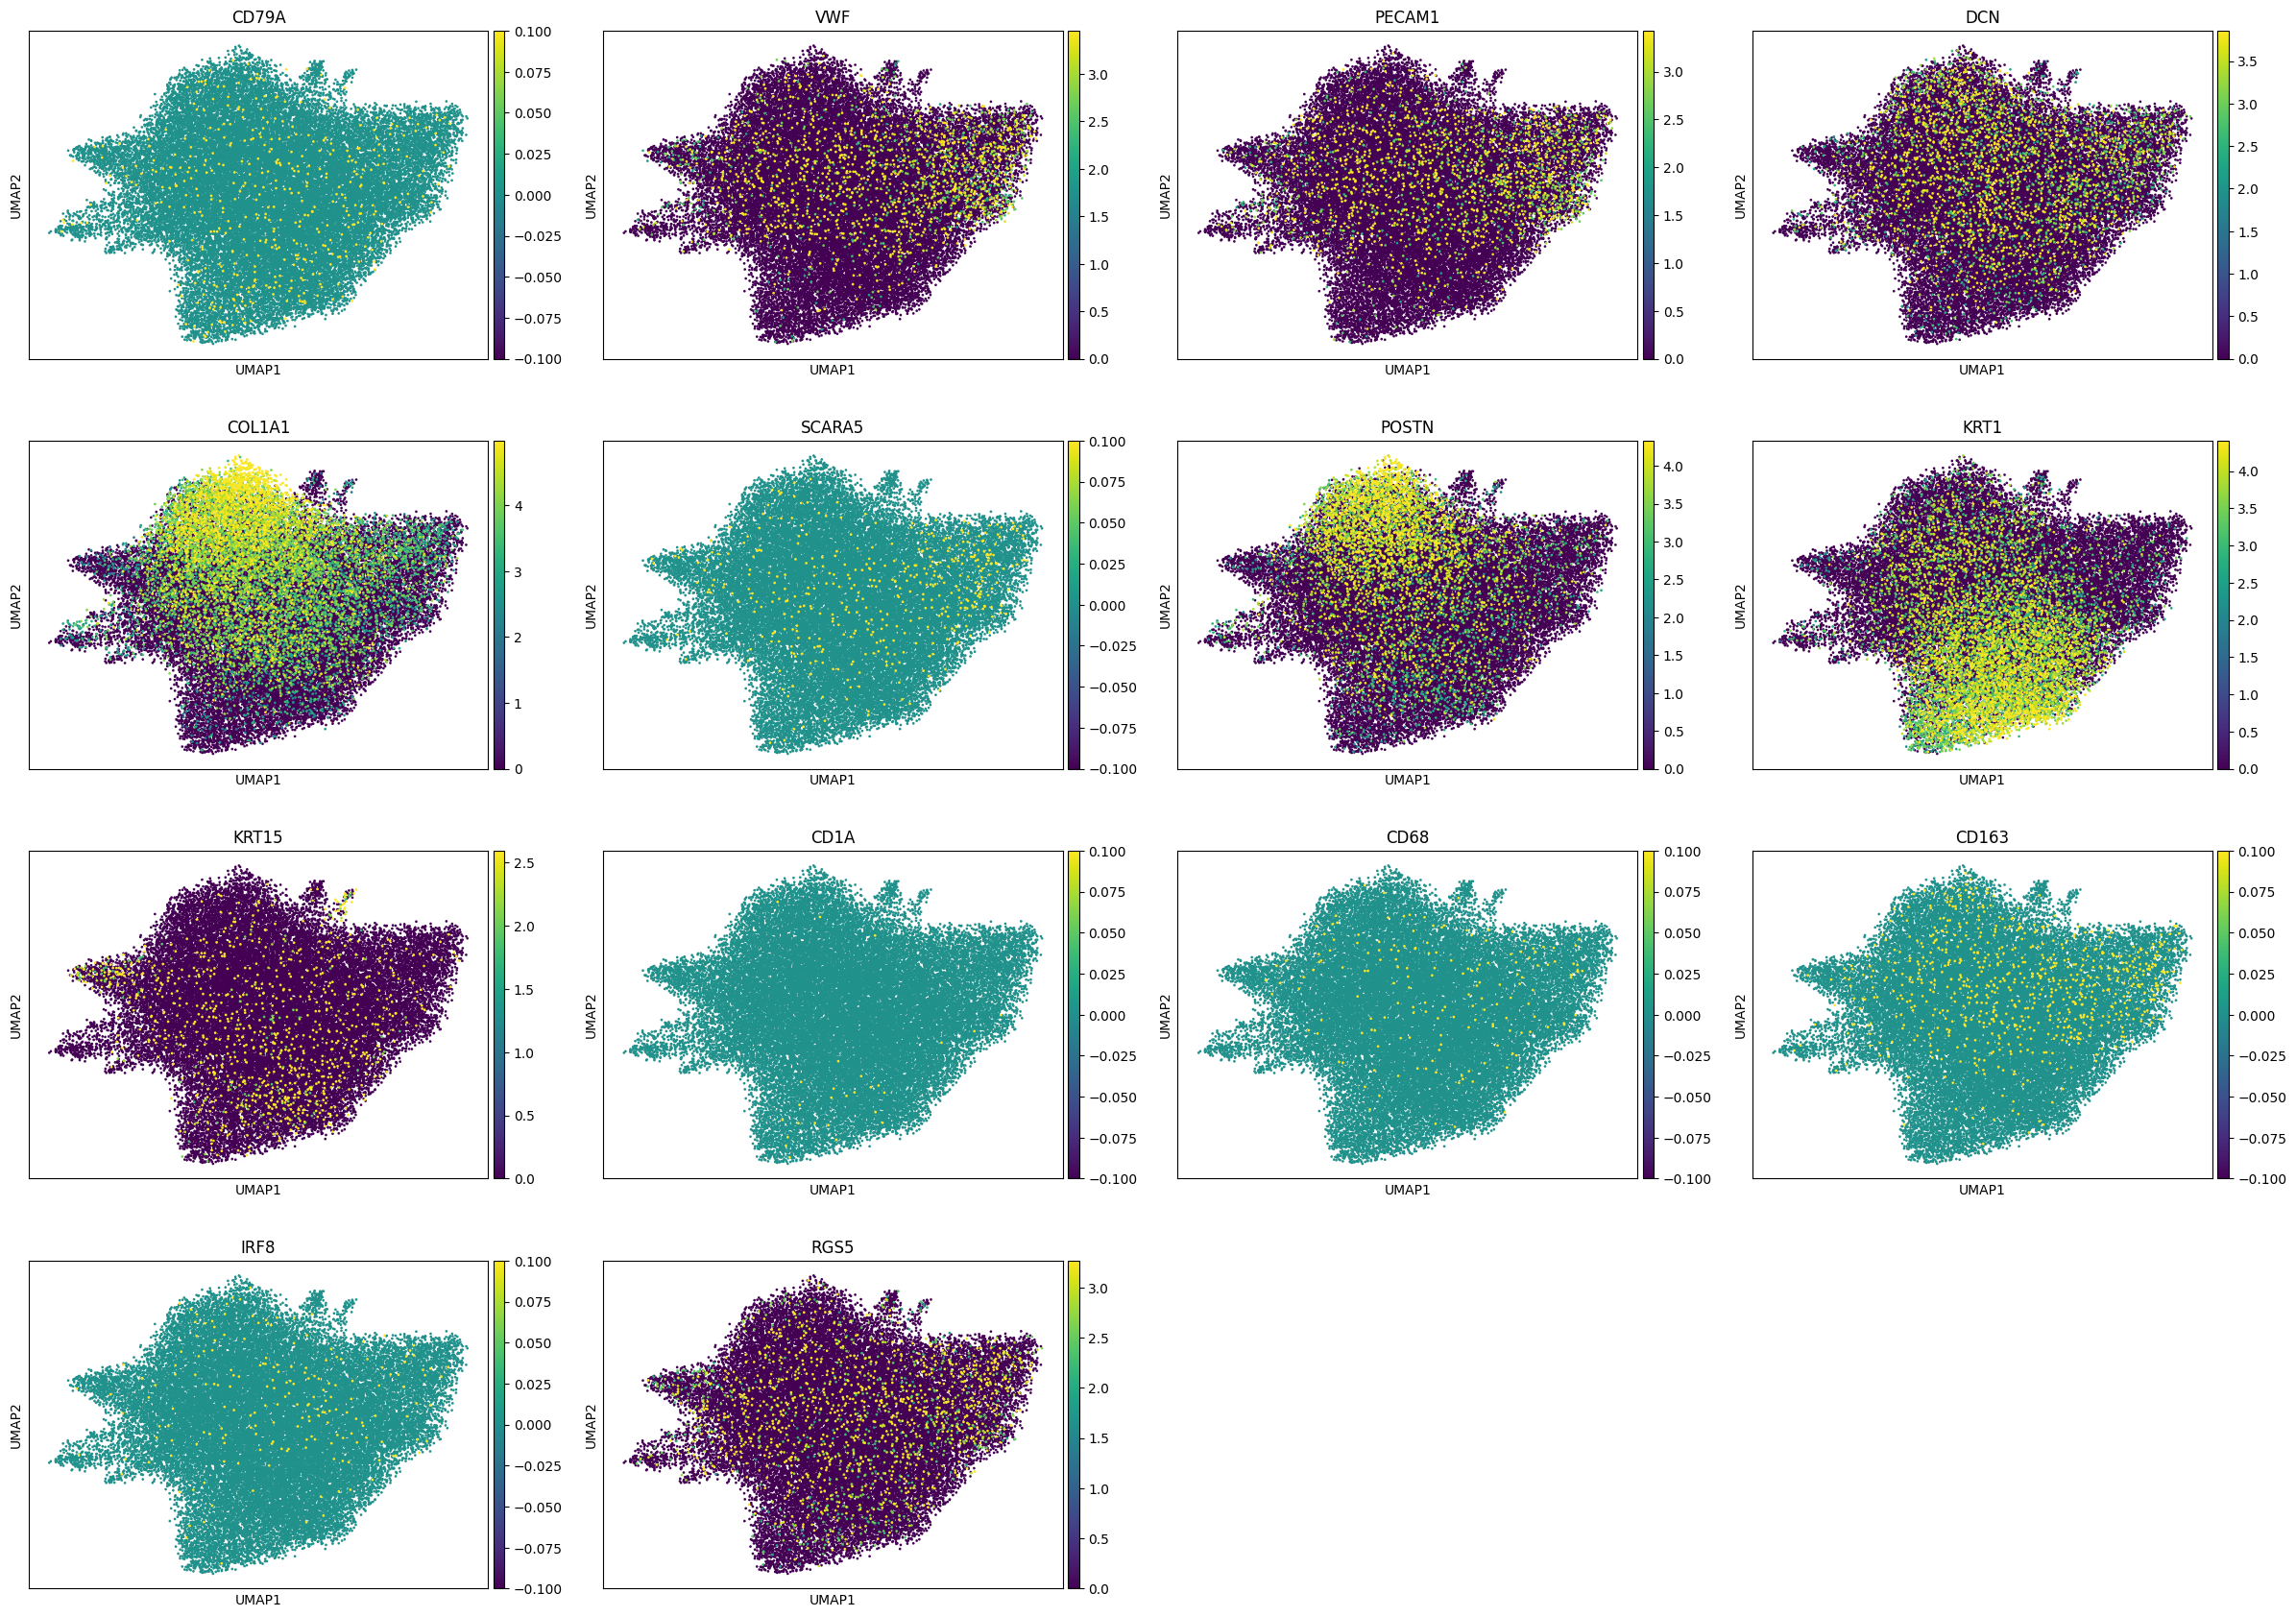

In [14]:
sc.pl.umap(
    adata,
    color=["CD79A", "VWF", "PECAM1", "DCN", "COL1A1", "SCARA5", "POSTN",
           "KRT1", "KRT15", "CD1A", "CD68", "CD163",
           "IRF8", "RGS5"],
    size=15,
    vmax='p98'
)

In [15]:
adata.write_h5ad(f"{out_dir}/adata.h5ad")